# A few useful things to know about machine learning - Pedro Domingos

Some claims to explore: <i>Intuition Fails in High Dimensions</i>

> "Consider a nearest neighbor classifier with Hamming distance as the similarity measure, and sup- pose the class is just x1 ∧ x2. If there are no other features, this is an easy problem. But if there are 98 irrelevant features x3,..., x100, the noise from them completely swamps the signal in x1 and x2, and nearest neighbor effectively makes random predictions." - p5

> "Even more disturbing is that nearest neighbor still has a problem even if all 100 features are relevant!" - p5

[The failure of nearest neighbors](#knnfail) 

[Counterintuition](#counter)

I originally though the curse of dimensionality was mostly about increasing complexity, but proving this below, irrelevant features and noise makes metric-based learning completely random. We will also try to take a look at how [multivariate gaussians, oranges, and hypercubes] are distributed. Hint: not how you think.

[Blessing of Non-Uniformity](#BoNU)

The silver lining is the <i>blessing of non-uniformity</i>, which refers to the phenomenon that any low-dimensional manifold holding this data has the points very close to each other relative to the entire space. 

> ".. the space of digit images is much smaller than the space of all possible images" - p6

Follow-up:
- What about redundant features? 
- Why doesn't our KNN do much worse when we sample close to the classes?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches


<a name="BoNU"> <h2>Let's show that in a high-dimensional space like an image, the images of interest that we care about lie on a low-D manifold<h2> </a>
Note: if you randomly generate pixels in this dimension, you will only ever get static



In [2]:
from sklearn.datasets import load_digits
import cv2 
digits = load_digits()

In [3]:
seven = digits.images[6]

In [4]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

# What about translations?

# what about zoom out and in? 

In [5]:
sevens_rotated = np.array([rotate_image(seven, x) for x in range(0, 360)])

In [6]:
sevens_rotated_reshape = np.reshape(sevens_rotated, (len(sevens_rotated), 8*8))

In [8]:
pca = PCA(n_components=3, svd_solver='arpack')
transformed = pca.fit_transform(sevens_rotated_reshape)
print(pca.explained_variance_ratio_)

[0.21076772 0.19935402 0.16212051]


In [9]:
from sklearn.manifold import TSNE
sevens_rotated_tsne = TSNE(n_components=3).fit_transform(sevens_rotated_reshape)


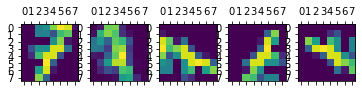

In [10]:
fig = plt.figure()
for i, angle in enumerate([0, 45, 90, 180, 270]):
    ax = fig.add_subplot(1, 5, i+1)
    ax.matshow(sevens_rotated[angle])


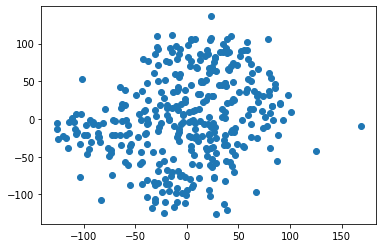

In [12]:

plt.scatter(sevens_rotated_tsne[:,0:1], sevens_rotated_tsne[:,1:2])

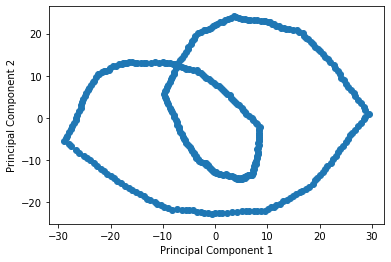

In [13]:
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.scatter(transformed[:,:1], transformed[:,1:2])

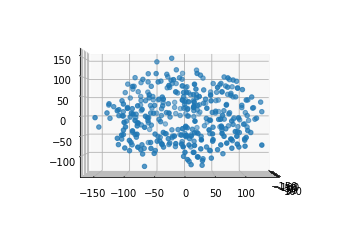

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=sevens_rotated_tsne[:,:1], ys=sevens_rotated_tsne[:,1:2], zs=sevens_rotated_tsne[:,2:])
ax.view_init(0, 0)

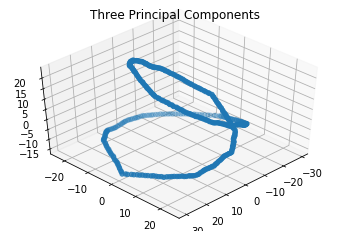

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=transformed[:,:1], ys=transformed[:,1:2], zs=transformed[:,2:])
plt.title("Three Principal Components")

ax.view_init(45, 45)

In [138]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()


In [139]:
np.shape(faces.images)

(400, 64, 64)

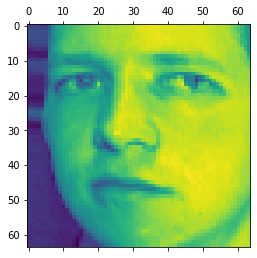

In [140]:
plt.matshow(faces.images[3])

In [159]:
pca = PCA(n_components=2, svd_solver='arpack')
transformed = pca.fit_transform(faces.data)
print(pca.explained_variance_ratio_)

[0.2381273  0.13993974]


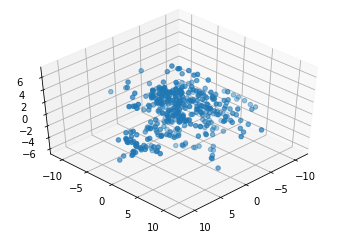

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=transformed[:,:1], ys=transformed[:,1:2], zs=transformed[:,2:])
ax.view_init(45, 45)

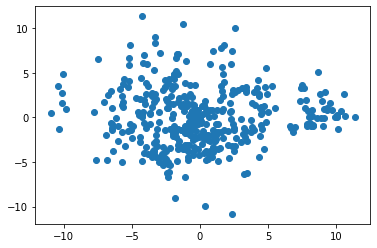

In [150]:
plt.scatter(transformed[:,:1], transformed[:,1:2])

In [154]:
# what about a TSNE? Is PC the only way?
#face_tsne = TSNE(n_components=2).fit(faces.data)
faces_tsne = TSNE(n_components=2).fit_transform(faces.data)

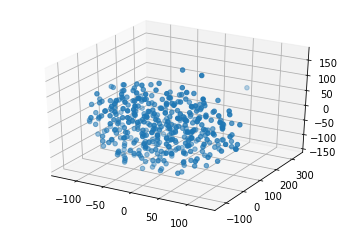

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=faces_tsne[:,:1], ys=faces_tsne[:,1:2], zs=faces_tsne[:,2:])

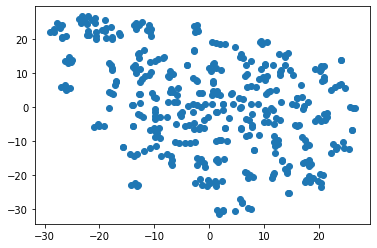

In [155]:
plt.scatter(faces_tsne[:,:1], faces_tsne[:,1:])

## Inversely draw from this low-dimensional manifold.

In [160]:
#pca.inverse_transform
x_min = min(transformed[:, :1])
x_max = max(transformed[:, :1])
y_min = min(transformed[:, 1:2])
y_max = max(transformed[:, 1:2])

x = np.random.uniform(x_min, x_max, (100, 1))
y = np.random.uniform(y_min, y_max, (100, 1))
sample = np.concatenate((x, y), axis=1)
#print(sample)

inverse_samples = pca.inverse_transform(sample)
inverse_samples_reshaped = np.reshape(inverse_samples, (100, 64, 64))


In [161]:
np.shape(inverse_samples)

(100, 4096)

<Figure size 432x288 with 0 Axes>

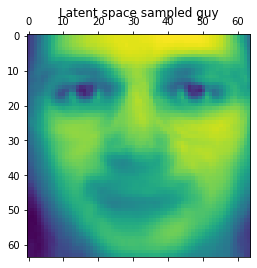

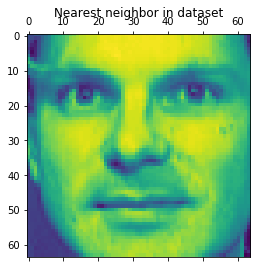

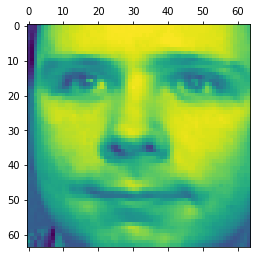

In [163]:
# try your nearest neighbor!
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(faces.data)
distances, indices = nbrs.kneighbors(inverse_samples)
fig = plt.figure()

#ax = fig.add_subplot('12' + str(i+1))
plt.matshow(inverse_samples_reshaped[6])
#ax = fig.add_subplot('12' + str(i+2))
plt.title("Latent space sampled guy")
plt.matshow(faces.images[indices[6][0]])
plt.title("Nearest neighbor in dataset")
plt.matshow(faces.images[indices[6][1]])
plt.show()

In [ ]:
np.shape(face_tsne.embedding_)

# how does inverse work again? 

# what really is a T-SNE? 